# 1D Token-Sequence Prediction

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf, pacf
from collections import Counter
import matplotlib.pyplot as plt

#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

$W_t \sim \mathcal{N}(0, t)$

$dW_t \approx W_{t+\Delta t} - W_t \sim \mathcal{N}(0, \Delta t)$

$\ln(S_t) \sim \mathcal{N}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$S_t \sim \text{LogNormal}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$dS_t \sim \mathcal{N}(\mu S_t dt, \sigma^2 S_t^2 dt)$


In [3]:
def gbm_simulator(key, S0, mu, sigma, T, dt, n):

    # Time vector
    t = jnp.linspace(0, T, n)
    
    # Generate Wiener process increments
    W_increments = random.normal(key, (n,)) * jnp.sqrt(dt)
    
    # Cumulative sum to get the Wiener process
    W = jnp.cumsum(W_increments)
    
    # Geometric Brownian Motion
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    
    return t, S

# Parameters for the GBM
S0 = 100.0      # Initial stock price
mu = 0.1        # Drift coefficient (e.g., 10% annual drift)
sigma = 0.2     # Volatility coefficient (e.g., 20% annual volatility)
T = 1.0         # Total time (5 year)
n = 20000       # Number of time steps
dt = T / n      # Time step size

key = random.PRNGKey(1)

# Simulate GBM
t, Price_GBM = gbm_simulator(key, S0, mu, sigma, T, dt, n)

# Price Deltas
Delta_GBM = jnp.diff(Price_GBM)

Data Illustration

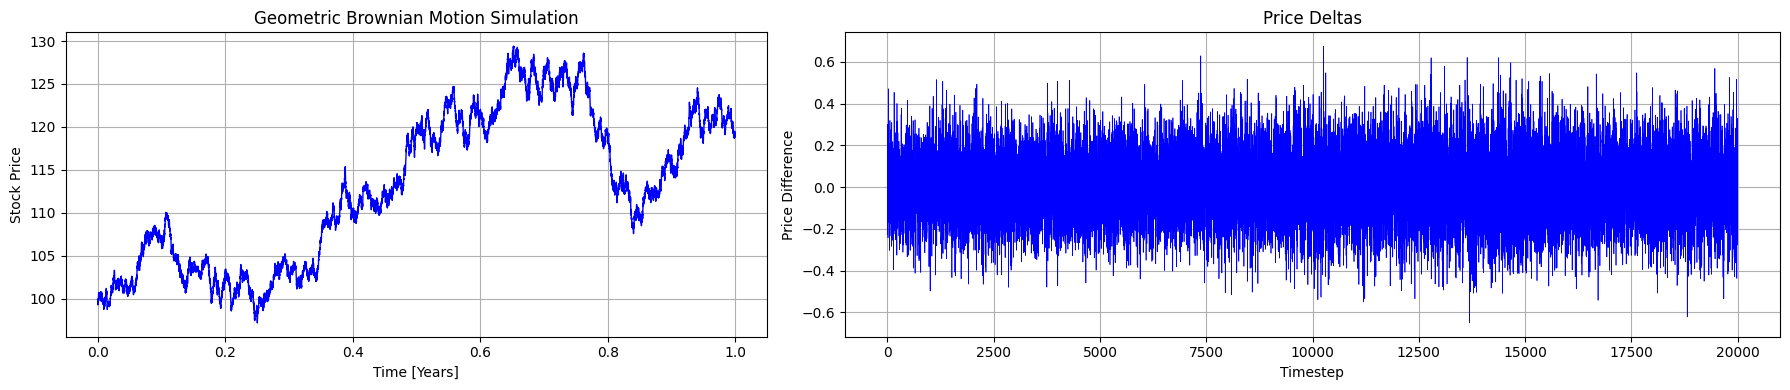

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [1.5, 2]})
axs[0].plot(t, Price_GBM, color='blue', linewidth=1)
axs[0].set_title('Geometric Brownian Motion Simulation')
axs[0].set_xlabel('Time [Years]')
axs[0].set_ylabel('Stock Price')
axs[0].grid('True')

axs[1].plot(Delta_GBM, color='blue', linewidth=0.5)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Difference')
axs[1].grid('True')
plt.tight_layout()
plt.show()

BINWIDTH

In [34]:
bin_width = 0.1

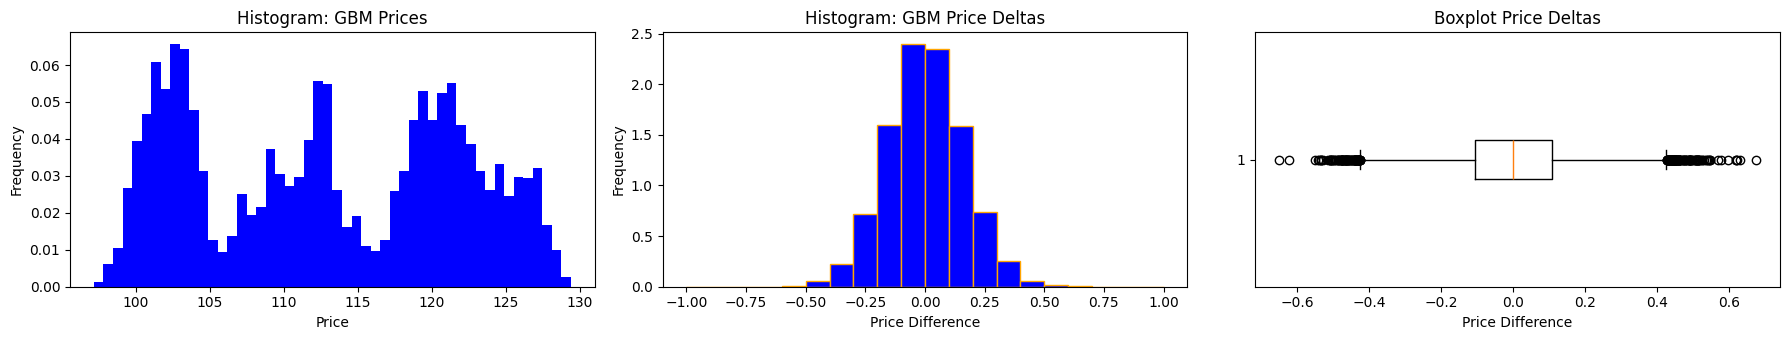

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM, bins=50, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-1, 1 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM, bins=bins, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM, vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Discretizing Data and Train-Val-Test Split

In [36]:
data = np.array(Delta_GBM)

# Bin range and Bin width
bin_start = -1.0
bin_stop = 1.0

num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

# Tokenize the data
tokenized_data = np.digitize(data, bins=bin_edges, right=False) - 1

# Clip any deltas below -0.7 to the first bin and above 0.7 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)

# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.7, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

LSTM Model

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

#### Train setting:

| Train set:                           |     $\approx$ 14'000         |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |
| Sequences for a full epoch:          | $\approx$ 280                |
| **Batch size:**                      | **32**                       |
| Episode length:                      | 1 Batch or 10 sequences      |


PARAMETERS

In [39]:
seq_len = 50                                                    # Sequence Length
batch_size = 32                                                 # Batch Size
learning_rate = 0.001                                           # Learning Rate Adam Optimizer
num_episodes = int(len(train_data_temp)/(seq_len*batch_size))   # Number of episodes for one Epoch

num_epochs = 200

VALIDATION & TEST DATA

In [40]:
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_val_seq)]

n_test_seq = len(test_data_temp) // seq_len
test_data = [test_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_test_seq)]

TRAINING

In [41]:
ss_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ss_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    avg_train_loss = 0
    avg_val_loss = 0

    for episode in range(num_episodes):

        ## ============
        ## TRAINING
        ## ============

        ss_model.train()
        ss_model.zero_grad()

        # Sample the Batch 
        start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=batch_size, replace=True)
        train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
        
        # Create Tensor of Sequence and Target
        sequence_inputs = torch.tensor([seq[:-1] for seq in train_data])    # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in train_data])             # Remove First Token

        # Forward pass: Shape [batch_size, sequence_length - 1, output_dim]
        logits, _ = ss_model(sequence_inputs)

        # [batch_size*sequence_length-1, output_dim/unique Tokens]
        logits = logits.view(-1, logits.size(-1))
        # Flatten targets: [batch_size*sequence_length-1]
        targets = targets.view(-1)

        loss = criterion(logits, targets)          # Loss
        loss.backward()                            # Backward pass
        optimizer.step()                           # Update weights
        avg_train_loss += loss.item()              # Save Loss

        ## ============
        ## VALIDATION
        ## ============
        
        ss_model.eval()
        
        sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in val_data])
        
        with torch.no_grad():
            logits, _ = ss_model(sequence_inputs)       # Forward Pass
            logits = logits.view(-1, logits.size(-1))   # Flatten Logits
            targets = targets.view(-1)                  # Flatten targets
            loss = criterion(logits, targets)           # Loss
            avg_val_loss += loss.item()                 # Save Loss
    
    epoch_train_loss = avg_train_loss/num_episodes      # Avg Train Loss after Epoch
    epoch_val_loss = avg_val_loss/num_episodes          # Avg Val Loss after Epoch
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = best_val_loss
        torch.save(ss_model.state_dict(), 'ss_model_weights.pth')
    
    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 0 - Train Loss: 2.9428 - Val Loss: 2.9330
Epoch 1 - Train Loss: 2.7159 - Val Loss: 2.7202
Epoch 2 - Train Loss: 2.3623 - Val Loss: 2.3816
Epoch 3 - Train Loss: 2.0844 - Val Loss: 2.1541
Epoch 4 - Train Loss: 1.9684 - Val Loss: 2.0781
Epoch 5 - Train Loss: 1.9217 - Val Loss: 2.0459
Epoch 6 - Train Loss: 1.9235 - Val Loss: 2.0274
Epoch 7 - Train Loss: 1.9222 - Val Loss: 2.0136
Epoch 8 - Train Loss: 1.8954 - Val Loss: 2.0062
Epoch 9 - Train Loss: 1.9251 - Val Loss: 2.0072
Epoch 10 - Train Loss: 1.9190 - Val Loss: 2.0051
Epoch 11 - Train Loss: 1.9058 - Val Loss: 2.0017
Epoch 12 - Train Loss: 1.9018 - Val Loss: 2.0014
Epoch 13 - Train Loss: 1.9033 - Val Loss: 2.0008
Epoch 14 - Train Loss: 1.8975 - Val Loss: 2.0014
Epoch 15 - Train Loss: 1.8927 - Val Loss: 2.0013
Epoch 16 - Train Loss: 1.8907 - Val Loss: 1.9995
Epoch 17 - Train Loss: 1.8832 - Val Loss: 2.0003
Epoch 18 - Train Loss: 1.8884 - Val Loss: 1.9991
Epoch 19 - Train Loss: 1.8919 - Val Loss: 1.9991
Epoch 20 - Train Loss: 1.8915 

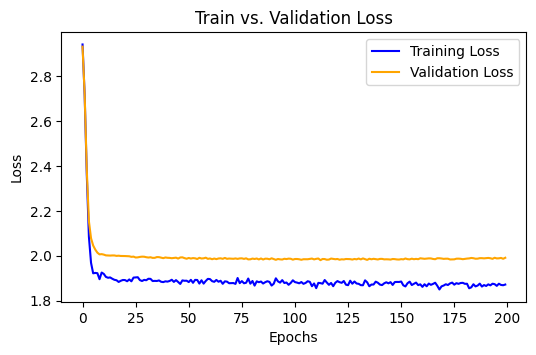

In [42]:
plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [199]:
# ## NUMBER OF BINS: 6
# train_loss_02 = train_losses
# val_loss_02 = val_losses
# ## NUMBER OF BINS 13
# train_loss_01 = train_losses
# val_loss_01 = val_losses
# ## NUMBER OF BINS 27
# train_loss_005 = train_losses
# val_loss_005 = val_losses

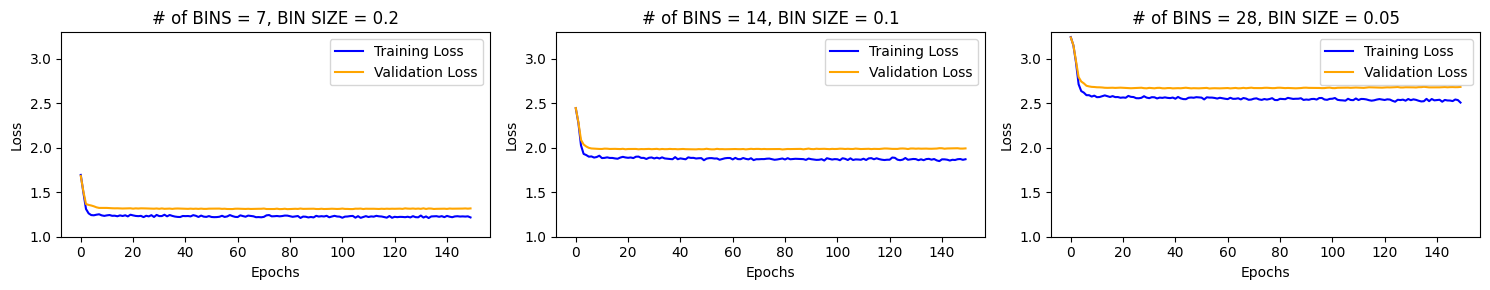

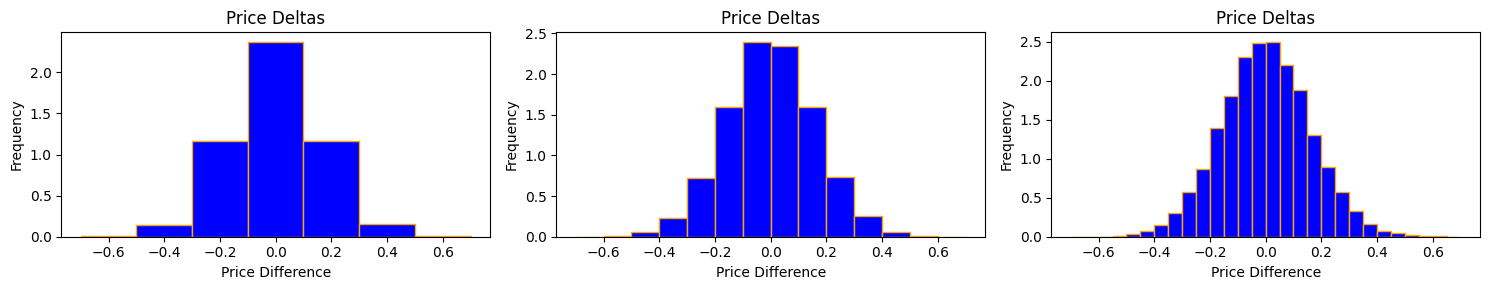

In [277]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

axs[0].plot(train_loss_02, label='Training Loss', color='blue')
axs[0].plot(val_loss_02, label = 'Validation Loss', color='orange')
axs[0].set_title('# of BINS = 7, BIN SIZE = 0.2')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(1,3.3)
axs[0].legend()

axs[1].plot(train_loss_01, label='Training Loss', color='blue')
axs[1].plot(val_loss_01, label = 'Validation Loss', color='orange')
axs[1].set_title('# of BINS = 14, BIN SIZE = 0.1')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(1,3.3)
axs[1].legend()

axs[2].plot(train_loss_005, label='Training Loss', color='blue')
axs[2].plot(val_loss_005, label = 'Validation Loss', color='orange')
axs[2].set_title('# of BINS = 28, BIN SIZE = 0.05')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_ylim(1,3.3)
axs[2].legend()

plt.tight_layout()
plt.show()

bins_005 = np.arange(-0.7, 0.7 + 0.05, 0.05)
bins_01 = np.arange(-0.7, 0.7 + 0.1, 0.1)
bins_02 = np.arange(-0.7, 0.7 + 0.2, 0.2)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

# Histogram: GBM Price Deltas
axs[0].hist(Delta_GBM, bins=bins_02, edgecolor='orange', color='blue', density=True)
axs[0].set_title('Price Deltas')
axs[0].set_xlabel('Price Difference')
axs[0].set_ylabel('Frequency')

axs[1].hist(Delta_GBM, bins=bins_01, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

axs[2].hist(Delta_GBM, bins=bins_005, edgecolor='orange', color='blue', density=True)
axs[2].set_title('Price Deltas')
axs[2].set_xlabel('Price Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### EVALUATION AND TESTING with Teacher forcing

In [43]:
start_val_idx = np.random.choice(range(len(val_data_temp)-seq_len), size=200, replace=True)
val_data_eval = prep_data(seq_len=seq_len, start_indexes=start_val_idx, data=val_data_temp)

start_test_idx = np.random.choice(range(len(test_data_temp)-seq_len), size=200, replace=True)
test_data_eval = prep_data(seq_len=seq_len, start_indexes=start_test_idx, data=test_data_temp)

In [44]:
evaluation_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
evaluation_model.load_state_dict(torch.load('ss_model_weights.pth', weights_only=False))

val_loss = []
val_perplexity = []

test_loss = []
test_perplexity = []

evaluation_model.eval()
with torch.no_grad():
    
    # Validation Data
    for sequence in val_data_eval:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input)                # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49]
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)
    
    for sequence in test_data_eval:

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input)                # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

Perplexity Score


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$

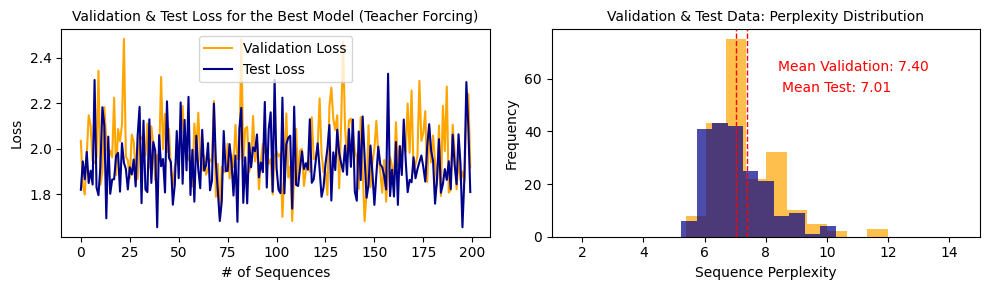

In [45]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].plot(test_loss, label='Test Loss', color='darkblue')
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')

# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=10, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=10, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(1,15)

# Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val+1.0, axs[1].get_ylim()[1] * 0.8, f'Mean Validation: {mean_val:.2f}', color='red')
axs[1].text(mean_test+1.5, axs[1].get_ylim()[1] * 0.7, f'Mean Test: {mean_test:.2f}', color='red')

plt.tight_layout()
plt.show()


#### Inference on Test Data

In [46]:
test_losses = []
trajectories = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)

Entropy of the Distribution (Test data)

Shannon Entropy  $H(\text{x}) = - \sum_{i} p(\text{x}_i) \log p(\text{x}_i)$


In [47]:
def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

In [48]:
calculate_entropy(val_data_temp)

1.9698274339615593

In [49]:
calculate_entropy(train_data_temp)

1.882161836426398

REAL DATA Token level entropy: 1.9209
FAKE DATA Token level entropy: 2.066


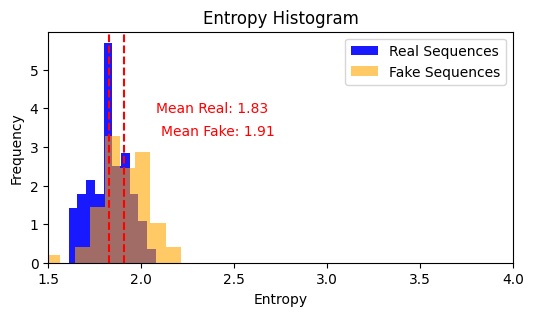

In [50]:
pure_fake = [trajectories[i][1:] for i in range(len(trajectories))]
flatten_fake = [token for seq in pure_fake for token in seq]

real_entropy = round(calculate_entropy(test_data_temp), 4)
fake_entropy = round(calculate_entropy(flatten_fake), 4)


print(f"REAL DATA Token level entropy: {real_entropy}")
print(f"FAKE DATA Token level entropy: {fake_entropy}")

real_seq_entropy = []
fake_seq_entropy = []
for i in range(len(test_data)):
    real_seq_entropy.append(calculate_entropy(test_data[i]))
    fake_seq_entropy.append(calculate_entropy(pure_fake[i]))

plt.figure(figsize=(6, 3))

# Plot histograms
plt.hist(real_seq_entropy, color='blue', alpha=0.9, label='Real Sequences', density=True)
plt.hist(fake_seq_entropy, color='orange', alpha=0.6, label='Fake Sequences', density=True)

# Calculate means
mean_real = np.mean(real_seq_entropy)
mean_fake = np.mean(fake_seq_entropy)

# Plot vertical lines for means
plt.axvline(mean_real, color='red', linewidth=1.5, linestyle='dashed')
plt.axvline(mean_fake, color='red', linewidth=1.5, linestyle='dashed')
plt.text(mean_real + 0.25, plt.gca().get_ylim()[1] * 0.65, f'Mean Real: {mean_real:.2f}', color='red')
plt.text(mean_fake + 0.2, plt.gca().get_ylim()[1] * 0.55, f'Mean Fake: {mean_fake:.2f}', color='red')

# Set titles and labels
plt.title('Entropy Histogram')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.xlim(1.5,4)
plt.legend()
plt.show()


Trajectories

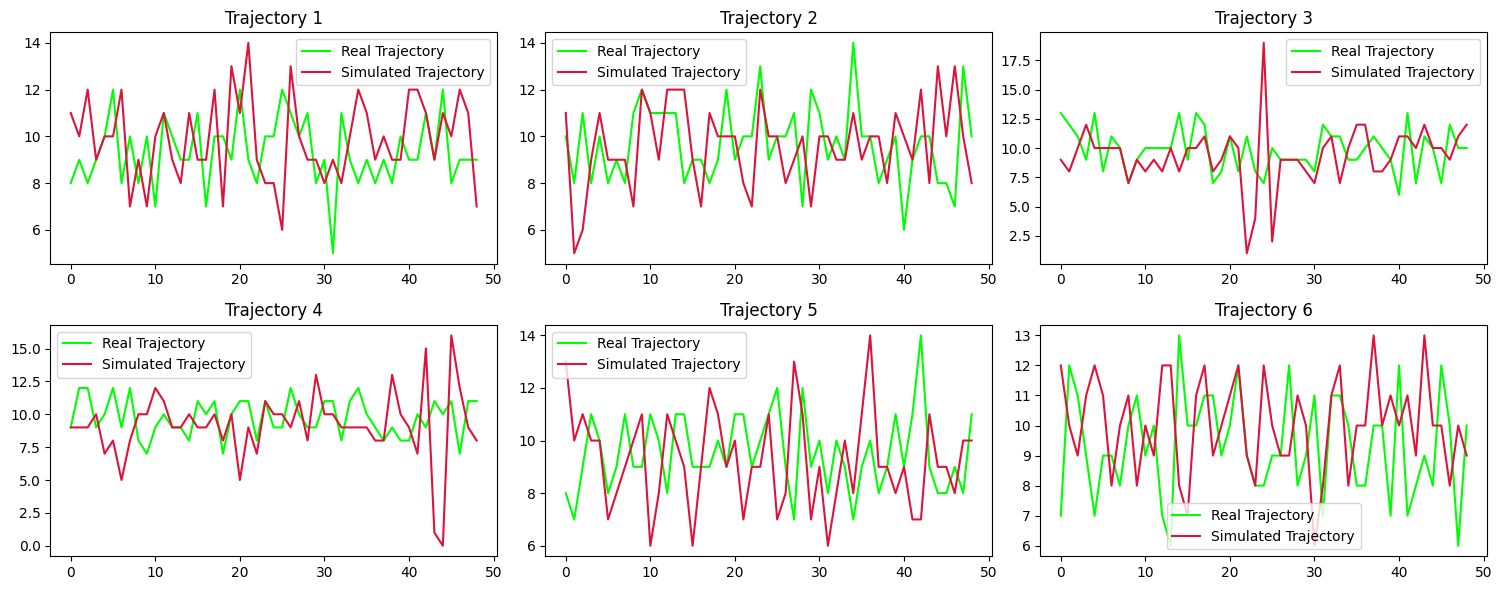

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color = 'lime')
    axes[i].plot(pure_fake[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Inference with ARGMAX instead of SAMPLING next TOKEN

In [52]:
test_losses_2 = []
trajectories_2 = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.argmax(probs).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses_2.append(token_loss/len(sequence))
        trajectories_2.append(sim_trajectory)

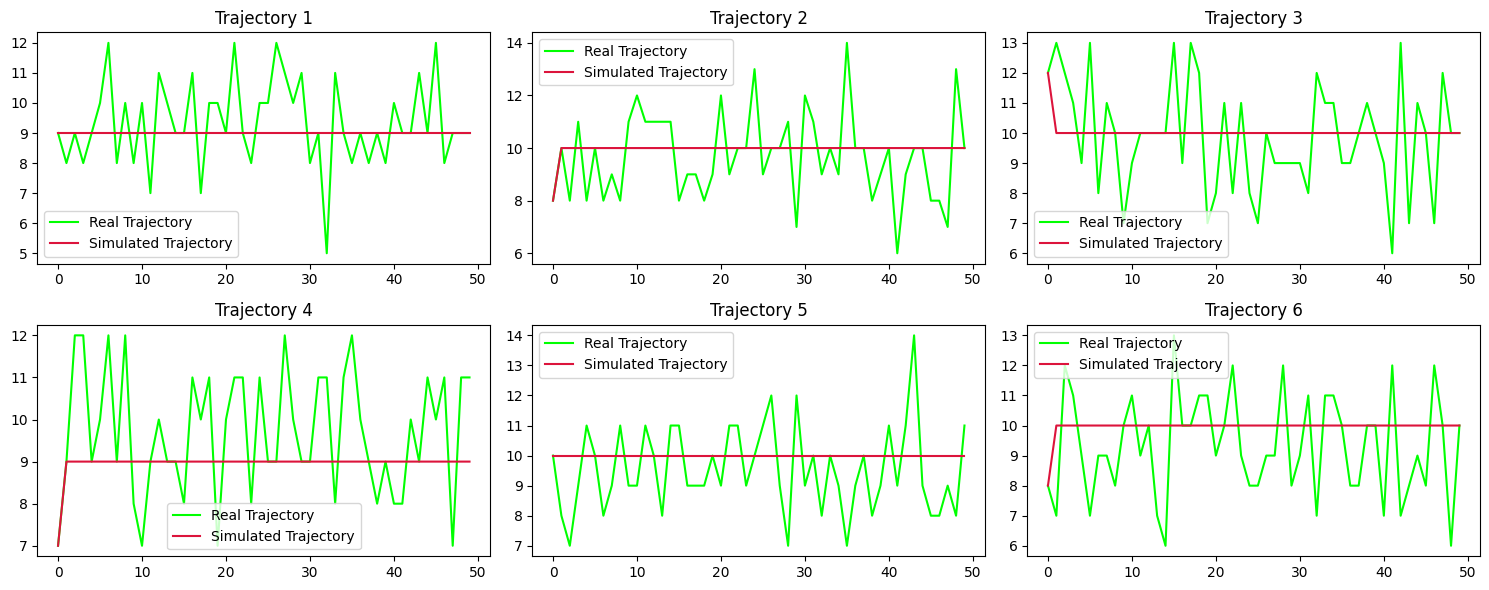

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories_2[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

#### Summary Statistics

In [54]:
def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(pure_fake)

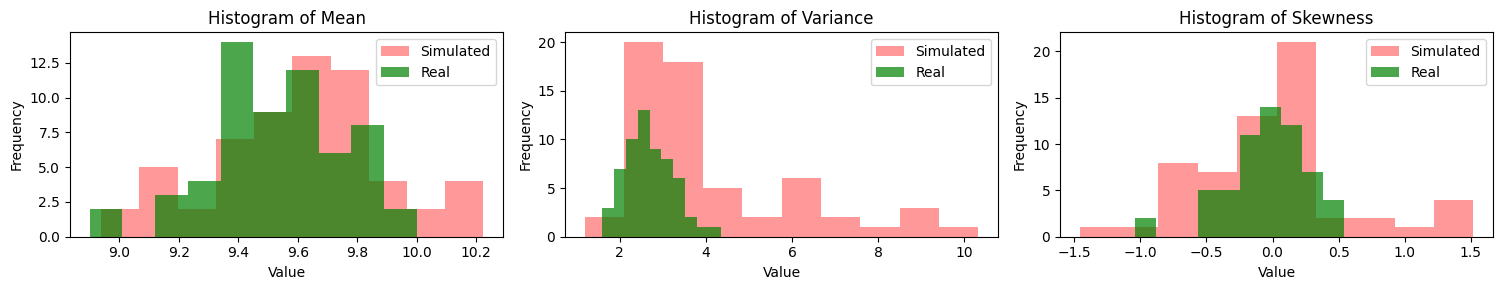

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, alpha=0.4, label='Simulated', color='red')
axs[0].hist(real_means, alpha=0.7, label='Real', color='green')
axs[0].legend(loc='upper right')
axs[0].set_title('Histogram of Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, alpha=0.4, label='Simulated', color='red')
axs[1].hist(real_variances,alpha=0.7, label='Real', color='green')
axs[1].legend(loc='upper right')
axs[1].set_title('Histogram of Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, alpha=0.4, label='Simulated', color='red')
axs[2].hist(real_skew, alpha=0.7, label='Real', color='green')
axs[2].legend(loc='upper right')
axs[2].set_title('Histogram of Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

# # Plot 3: Kurtosis Distribution
# axs[2].hist(sim_kurtosis, bins=15, alpha=0.4, label='Simulated', color='red')
# axs[2].hist(real_kurtosis, bins=15, alpha=0.7, label='Real', color='green')
# axs[2].legend(loc='upper right')
# axs[2].set_title('Distribution of Kurtosis')
# axs[2].set_xlabel('Value')
# axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [64]:
len(real_variances)

60

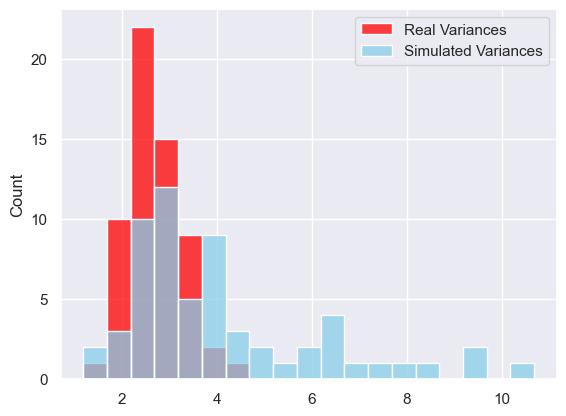

In [74]:
# libraries & dataset

bin_start = min(np.min(sim_variances), np.min(real_variances))
bin_stop = max(np.max(sim_variances), np.max(real_variances))
bin_width = 0.5
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

sns.histplot(real_variances, bins=bin_edges, color="red", label="Real Variances", kde=False)
sns.histplot(sim_variances, bins=bin_edges, color="skyblue", label="Simulated Variances", kde=False)


plt.legend() 
plt.show()

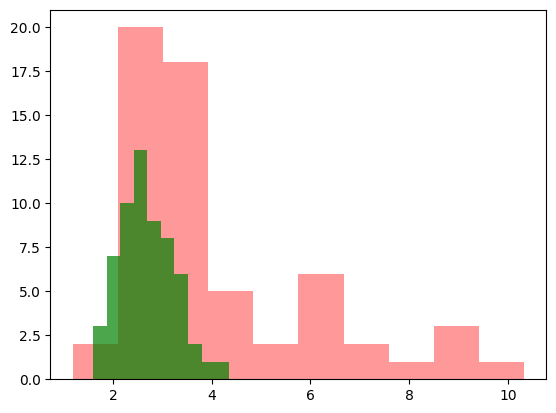

In [62]:
plt.hist(sim_variances, bins=10, alpha=0.4, label='Simulated', color='red')
plt.hist(real_variances, bins=10, alpha=0.7, label='Real', color='green')
plt.show()

Autocorrelation

$ACF(k) = Corr(x_t, x_{t-k})$

In [30]:
# Function to calculate ACF for each trajectory
def calculate_acf(trajectories, nlags=10):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

# Function to calculate PACF for each trajectory
def calculate_pacf(trajectories, nlags=10):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

# ACFs for real and simulated trajectories
real_acfs = calculate_acf([test_data[i][1:] for i in range(len(test_data))])
simulated_acfs = calculate_acf(pure_fake)
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf([test_data[i][1:] for i in range(len(test_data))])
simulated_pacfs = calculate_pacf(pure_fake)
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

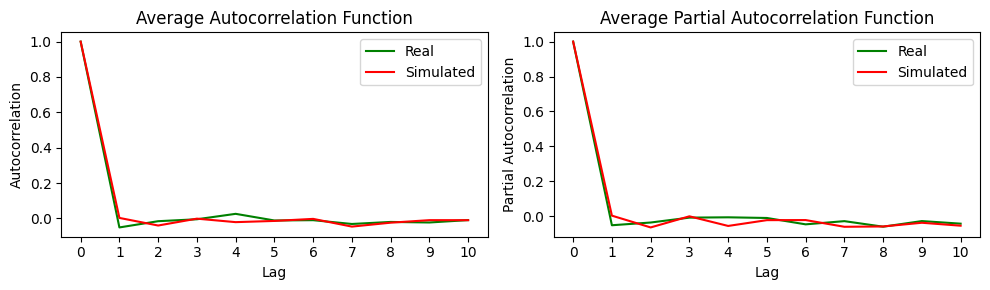

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xticks(np.arange(0, 11, 1))
axs[1].legend()

plt.tight_layout()
plt.show()


## NEXT PPO IMPLEMENTATION